In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Standard plotly imports
#import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools as tls
from plotly.offline import iplot, init_notebook_mode
#import cufflinks
#import cufflinks as cf
import plotly.figure_factory as ff

# Using plotly + cufflinks in offline mode
init_notebook_mode(connected=True)
#cufflinks.go_offline(connected=True)

# Preprocessing, modelling and evaluating
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from xgboost import XGBClassifier
import xgboost as xgb

## Hyperopt modules
from hyperopt import fmin, hp, tpe, Trials, space_eval, STATUS_OK, STATUS_RUNNING
from functools import partial

import os
import gc
print(os.listdir("../input"))

['test_identity.csv', 'sample_submission.csv', 'train_identity.csv', 'train_transaction.csv', 'test_transaction.csv']


#interactive plot 

In [2]:
# functions from: https://www.kaggle.com/kabure/baseline-fraud-detection-eda-interactive-views

def resumetable(df):
    print(f"Dataset Shape: {df.shape}")
    summary = pd.DataFrame(df.dtypes,columns=['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']]
    summary['Missing'] = df.isnull().sum().values    
    summary['Uniques'] = df.nunique().values
    summary['First Value'] = df.loc[0].values
    summary['Second Value'] = df.loc[1].values
    summary['Third Value'] = df.loc[2].values

    for name in summary['Name'].value_counts().index:
        summary.loc[summary['Name'] == name, 'Entropy'] = round(stats.entropy(df[name].value_counts(normalize=True), base=2),2) 

    return summary

def plot_distribution(df, var_select=None, title=None, bins=1.0): 
    # Calculate the correlation coefficient between the new variable and the target
    tmp_fraud = df[df['isFraud'] == 1]
    tmp_no_fraud = df[df['isFraud'] == 0]    
    corr = df['isFraud'].corr(df[var_select])
    corr = np.round(corr,3)
    tmp1 = tmp_fraud[var_select].dropna()
    tmp2 = tmp_no_fraud[var_select].dropna()
    hist_data = [tmp1, tmp2]
    
    group_labels = ['Fraud', 'No Fraud']
    colors = ['seagreen','indianred', ]

    fig = ff.create_distplot(hist_data,
                             group_labels,
                             colors = colors, 
                             show_hist = True,
                             curve_type='kde', 
                             bin_size = bins
                            )
    
    fig['layout'].update(title = title+' '+'(corr target ='+ str(corr)+')')

    iplot(fig, filename = 'Density plot')
    
def plot_dist_churn(df, col, binary=None):
    tmp_churn = df[df[binary] == 1]
    tmp_no_churn = df[df[binary] == 0]
    tmp_attr = round(tmp_churn[col].value_counts().sort_index() / df[col].value_counts().sort_index(),2)*100
    print(f'Distribution of {col}: ')
    trace1 = go.Bar(
        x=tmp_churn[col].value_counts().sort_index().index,
        y=tmp_churn[col].value_counts().sort_index().values, 
        name='Fraud',opacity = 0.8, marker=dict(
            color='seagreen',
            line=dict(color='#000000',width=1)))

    trace2 = go.Bar(
        x=tmp_no_churn[col].value_counts().sort_index().index,
        y=tmp_no_churn[col].value_counts().sort_index().values,
        name='No Fraud', opacity = 0.8, 
        marker=dict(
            color='indianred',
            line=dict(color='#000000',
                      width=1)
        )
    )

    trace3 =  go.Scatter(   
        x=tmp_attr.sort_index().index,
        y=tmp_attr.sort_index().values,
        yaxis = 'y2', 
        name='% Fraud', opacity = 0.6, 
        marker=dict(
            color='black',
            line=dict(color='#000000',
                      width=2 )
        )
    )
    
    layout = dict(title =  f'Distribution of {str(col)} feature by %Fraud',
              xaxis=dict(type='category'), 
              yaxis=dict(title= 'Count'), 
              yaxis2=dict(range= [0, 15], 
                          overlaying= 'y', 
                          anchor= 'x', 
                          side= 'right',
                          zeroline=False,
                          showgrid= False, 
                          title= 'Percentual Fraud Transactions'
                         ))

    fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
    iplot(fig)

#load data

In [3]:
print('# File sizes')
for f in os.listdir('../input'):
    if 'zip' not in f:
        print(f.ljust(30) + str(round(os.path.getsize('../input/' + f) / 1000000, 2)) + 'MB')

# File sizes
test_identity.csv             25.8MB
sample_submission.csv         6.08MB
train_identity.csv            26.53MB
train_transaction.csv         683.35MB
test_transaction.csv          613.19MB


In [4]:
%%time
train_transaction = pd.read_csv('../input/train_transaction.csv', index_col='TransactionID')
test_transaction = pd.read_csv('../input/test_transaction.csv', index_col='TransactionID')
train_identity = pd.read_csv('../input/train_identity.csv', index_col='TransactionID')
test_identity = pd.read_csv('../input/test_identity.csv', index_col='TransactionID')
print ("Data is loaded!")

Data is loaded!
CPU times: user 46.8 s, sys: 10.6 s, total: 57.4 s
Wall time: 53.7 s


In [5]:
print('train_transaction shape is {}'.format(train_transaction.shape))
print('test_transaction shape is {}'.format(test_transaction.shape))
print('train_identity shape is {}'.format(train_identity.shape))
print('test_identity shape is {}'.format(test_identity.shape))

train_transaction shape is (590540, 393)
test_transaction shape is (506691, 392)
train_identity shape is (144233, 40)
test_identity shape is (141907, 40)


In [6]:
train_transaction.head()

,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,...,V330,V331,V332,V333,V334,V335,V336,V337,V338,V339
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
train_identity.head()

,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
TransactionID,,,,,,,,,,,,,,,,,,,,,
2987004,0.0,70787.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
2987008,-5.0,98945.0,NaN,NaN,0.0,-5.0,NaN,NaN,NaN,NaN,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
2987010,-5.0,191631.0,0.0,0.0,0.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,Windows
2987011,-5.0,221832.0,NaN,NaN,0.0,-6.0,NaN,NaN,NaN,NaN,...,chrome 62.0,NaN,NaN,NaN,F,F,T,T,desktop,NaN
2987016,0.0,7460.0,0.0,0.0,1.0,0.0,NaN,NaN,0.0,0.0,...,chrome 62.0,24.0,1280x800,match_status:2,T,F,T,T,desktop,MacOS


# transactionDT 는 timestamp가 아님
# 하지만, 잘활용해야함.. 

In [8]:
train_transaction['TransactionDT'].shape[0] , train_transaction['TransactionDT'].nunique()

(590540, 573349)

#data는 극도로 imbalance

1. upsampling, subsampling
2. focal loss
3. 직쏘 방법 (50%)

In [9]:
x = train_transaction['isFraud'].value_counts().index
y = train_transaction['isFraud'].value_counts().values

trace2 = go.Bar(
     x=x ,
     y=y,
     marker=dict(
         color=y,
         colorscale = 'Viridis',
         reversescale = True
     ),
     name="Imbalance",    
 )
layout = dict(
     title="Data imbalance - isFraud",
     #width = 900, height = 500,
     xaxis=go.layout.XAxis(
     automargin=True),
     yaxis=dict(
         showgrid=False,
         showline=False,
         showticklabels=True,
 #         domain=[0, 0.85],
     ), 
)
fig1 = go.Figure(data=[trace2], layout=layout)
iplot(fig1)

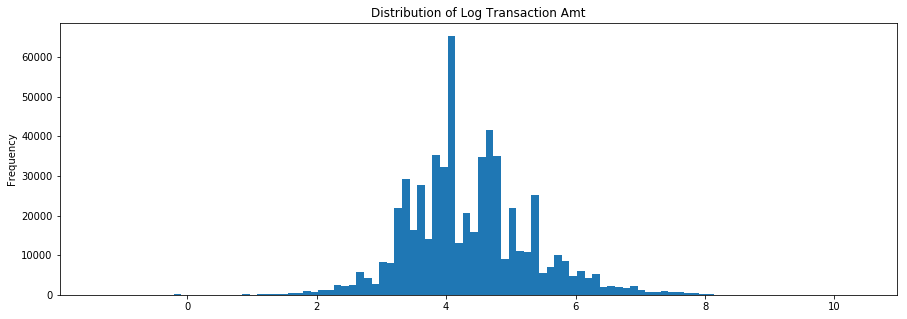

In [10]:
train_transaction['TransactionAmt'] \
    .apply(np.log) \
    .plot(kind='hist',
          bins=100,
          figsize=(15, 5),
          title='Distribution of Log Transaction Amt')
plt.show()

# fraud 일때, 더높은 average transaction ammount를 가짐. 
# (check) amt가 평균보다 높을 때 가중치 줌?

In [11]:
print('Mean transaction amt for fraud is {:.4f}'.format(train_transaction.loc[train_transaction['isFraud'] == 1]['TransactionAmt'].mean()))
print('Mean transaction amt for non-fraud is {:.4f}'.format(train_transaction.loc[train_transaction['isFraud'] == 0]['TransactionAmt'].mean()))

Mean transaction amt for fraud is 149.2448
Mean transaction amt for non-fraud is 134.5117


# ProductCD
- 

In [12]:
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]

# productCD에 대한 percentage
C의 경우 11%

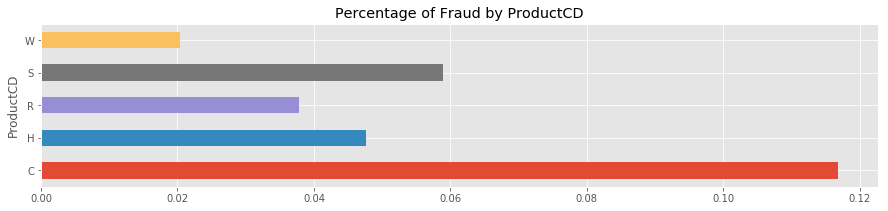

In [13]:
train_transaction.groupby('ProductCD')['isFraud'] \
    .mean() \
    .sort_index() \
    .plot(kind='barh',
          figsize=(15, 3),
         title='Percentage of Fraud by ProductCD')
plt.show()